In [1]:
import os, scipy, pickle, platform, sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import optimize
import matplotlib

from AaltoAtoms import CircCorralData, Spec, analyze_data, get_old_Ag_Co_corrals, fit_and_plot_functional_curve
from AaltoAtoms import show_waterfall, imshow_dIdV_vs_r
from AaltoAtoms.utils import labellines

from AaltoAtoms.Kondo_data_analysis.analyze_data import fit_and_plot_functional_curve
from AaltoAtoms.Kondo_data_analysis.analyze_data import plot_radial_width_dependence
from AaltoAtoms.Kondo_data_analysis.report_data import create_Co_cache, show_Co_waterfall, create_Ag_cache, show_Ag_waterfall, load_data, save_data
from AaltoAtoms.Kondo_data_analysis.report_data import fit_phenomenological_model
from AaltoAtoms.Kondo_data_analysis import data_array
from importlib import reload
from scipy.signal import decimate
from matplotlib.colors import LogNorm
from scipy.interpolate import interp2d
from itertools import combinations, repeat
from AaltoAtoms import CircCorralData, CircCorral


sys.modules['data_array'] = data_array
basepath = r"/Users/akipnis/Desktop/Aalto Atomic Scale Physics/modeling and analysis/data"
homedir = r"/Users/akipnis/Desktop/Aalto Atomic Scale Physics/modeling and analysis"
Co_Co_data_loc = os.path.join(basepath,'Co_Co_data.pickle')
Co_Ag_data_loc = os.path.join(basepath,'Co_Ag_data.pickle')
Co_Co_data, Co_Ag_data = load_data(Co_Co_data_loc, Co_Ag_data_loc)

%matplotlib notebook
import lmfit
from lmfit import model, parameter, minimizer
from numpy import exp, sin

from lmfit import minimize, Parameters, fit_report

No module named 'win32com'
Createc_Controller is None
minimize_manip_distance.py will not work
No module named 'win32com'
Createc_Controller is None
position_dependence_expt.py will not work


In [2]:
Co = np.array([[c['radius'], c['width']] for c in Co_Co_data]).T
Ag = np.array([[c['radius'], c['width']] for c in Co_Ag_data]).T

# Phenomenological model fitting
Several different phenomenological models successfully reproduce the trend in the Kond resonance width as a function of corral radius. This notebook iterates through the possible variations in the fit procedure, floating certain parameters while fixing others, and shows the results of the fit and the correlation between the varialbes. A large covariance between fit variables signifies overfitting.

# A: Fitting the models with js, jb, and delta floating, A fixed. 
Returns reasonable fits with js=jb

Problem: overfitting, the values for js and jb are negatively correlated 100%.

The returned values of js and jb also depend on the fixed value for A. 

Fixing A = 0.3 returns (0.4, 0.4)

Fixing A = 3 returns   (0.04, 0.56)

<IPython.core.display.Javascript object>


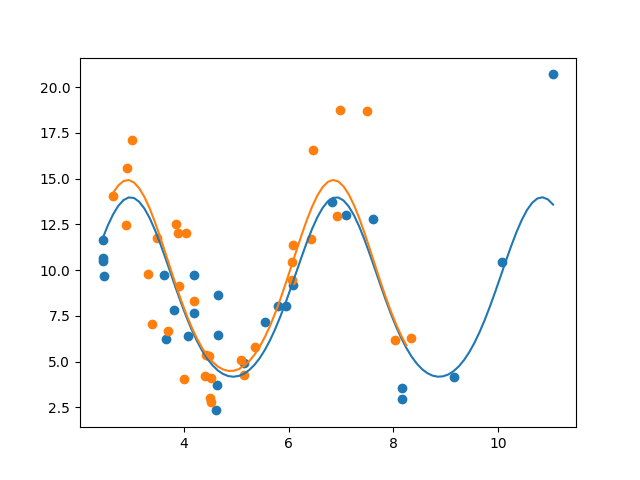

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 27
    # variables        = 3
    chi-square         = 149.000368
    reduced chi-square = 6.20834867
    Akaike info crit   = 52.1190216
    Bayesian info crit = 56.0065322
[[Variables]]
    rhos0:  0.125 (fixed)
    rhob:   0.27 (fixed)
    k:      0.8 (fixed)
    D:      4480 (fixed)
    js:     0.40011533 +/- 0.06661385 (16.65%) (init = 0.5)
    jb:     0.40109528 +/- 0.03414817 (8.51%) (init = 0.5)
    amp:    0.3 (fixed)
    delta:  1.51514699 +/- 0.12719962 (8.40%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(js, jb)    = -0.9881
    C(jb, delta) = +0.1754
    C(js, delta) = -0.1754
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 33
    # variables        = 3
    chi-square         = 235.525249
    reduced chi-square = 7.85084165
    Akaike info crit   = 70.8552486
    Bayesian info crit = 75.

In [49]:
plt.figure()

for d in [Ag, Co]:
    def model_(params, x):
        amp = params['amp']
        delta = params['delta']
        rhos0 = params['rhos0']
        rhob = params['rhob']
        k = params['k']
        D = params['D']
        jb = params['jb']
        js = params['js']

        model =  D*np.exp(-1./(jb*rhob+js*rhos0*(1+amp*np.cos(2.*k*x+delta))))
        return model
  
    def residual(params, x, data=None, uncertainty=None):
  
        model = model_(params, x)

        if uncertainty is None:
            return model - data
        return (model-data)/uncertainty

    params = Parameters()

    params.add('rhos0', value=0.125, vary=False)
    params.add('rhob', value=0.27, vary=False)
    params.add('k', value=0.8, vary=False)
    params.add('D', value=4480, min=3000, max=5000, vary=False)

    params.add('js', value=0.5, min=0, max=1, vary=True)
    params.add('jb', value=0.5, min=0, max=1, vary=True)
    params.add('amp', value=0.3, min=0, max=5, vary=False)
    params.add('delta', value=1, min=0, max=2*np.pi, vary=True)

    out = minimize(residual, params, args=(d[0],), kws={'data': d[1]})#, nan_policy='propagate')

    print(fit_report(out))

#    plt.figure()
    plt.scatter(d[0], d[1])
    #plt.plot(d[0], d[1]+out.residual)
    d0 = np.arange(min(d[0]), max(d[0]), 0.1)
    plt.plot(d0, model_(out.params, d0))

# B: Fitting with js=jb, delta and amplitude floating

<IPython.core.display.Javascript object>


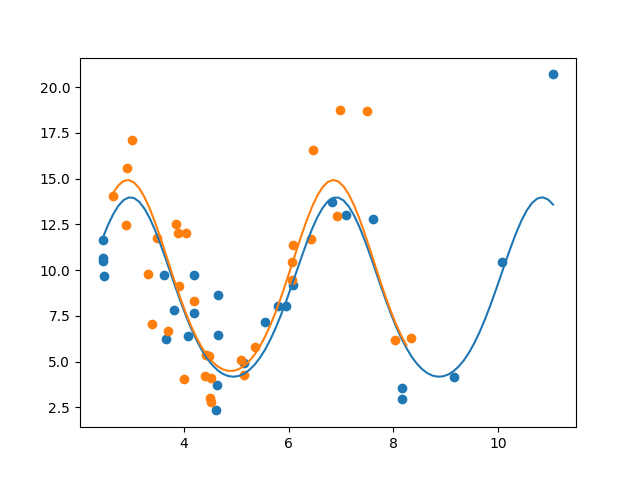

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 33
    # data points      = 27
    # variables        = 3
    chi-square         = 149.000368
    reduced chi-square = 6.20834867
    Akaike info crit   = 52.1190216
    Bayesian info crit = 56.0065322
[[Variables]]
    rhos0:  0.125 (fixed)
    rhob:   0.27 (fixed)
    k:      0.8 (fixed)
    D:      4480 (fixed)
    js:     0.40078513 +/- 0.00410250 (1.02%) (init = 0.5)
    jb:     0.40078513 +/- 0.00410250 (1.02%) == 'js'
    amp:    0.29949940 +/- 0.05141567 (17.17%) (init = 3)
    delta:  1.51514655 +/- 0.12719742 (8.40%) (init = 2)
[[Correlations]] (unreported correlations are < 0.100)
    C(js, amp)    = -0.5286
    C(amp, delta) = -0.1758
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 33
    # data points      = 33
    # variables        = 3
    chi-square         = 235.525249
    reduced chi-square = 7.85084165
    Akaike info crit   = 70.8552486
    Bayesian info crit = 

In [48]:
from numpy import exp, sin

from lmfit import minimize, Parameters, fit_report
plt.figure()
for d in [Ag, Co]:
    def model_(params, x):
        amp = params['amp']
        delta = params['delta']
        rhos0 = params['rhos0']
        rhob = params['rhob']
        k = params['k']
        D = params['D']
        jb = params['jb']
        js = params['js']

        model =  D*np.exp(-1./(jb*rhob+js*rhos0*(1+amp*np.cos(2.*k*x+delta))))
        return model
    
    def residual(params, x, data=None, uncertainty=None):
        model = model_(params, x)


        if uncertainty is None:
            return model - data
        return (model-data)/uncertainty

    params = Parameters()

    params.add('rhos0', value=0.125, vary=False)
    params.add('rhob', value=0.27, vary=False)
    params.add('k', value=0.8, vary=False)
    params.add('D', value=4480, min=3000, max=5000, vary=False)

    params.add('js', value=0.5, min=0, max=1, vary=True)
    params.add('jb', value=0.5, min=0, max=1, vary=True, expr='js')
    params.add('amp', value=3, min=0, max=5, vary=True)
    params.add('delta', value=2, min=0, max=2*np.pi, vary=True)

    out = minimize(residual, params, args=(d[0],), kws={'data': d[1]})#, nan_policy='propagate')

    print(fit_report(out))

    #
    plt.scatter(d[0], d[1])
#    plt.plot(d[0], d[1]+out.residual)
    d0 = np.arange(min(d[0]), max(d[0]), 0.1)
    plt.plot(d0, model_(out.params, d0))

# C: Fitting with no amplitude variable, only js and jb and delta

<IPython.core.display.Javascript object>


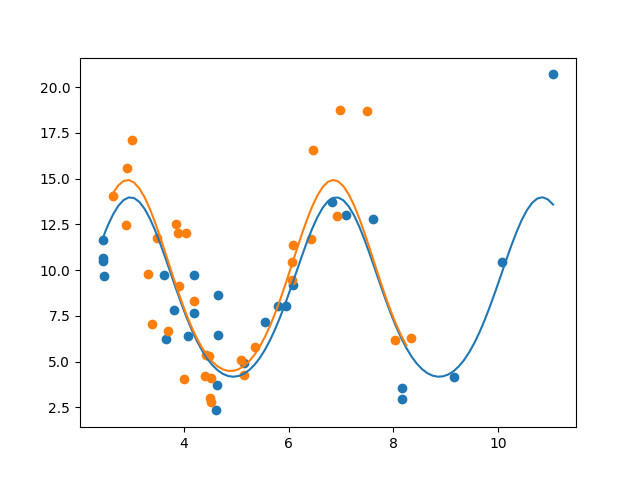

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 27
    # variables        = 3
    chi-square         = 149.000368
    reduced chi-square = 6.20834867
    Akaike info crit   = 52.1190216
    Bayesian info crit = 56.0065322
[[Variables]]
    rhos0:  0.125 (fixed)
    rhob:   0.27 (fixed)
    k:      0.8 (fixed)
    D:      4480 (fixed)
    js:     0.12003485 +/- 0.01998427 (16.65%) (init = 0.5)
    jb:     0.53076213 +/- 0.01324115 (2.49%) (init = 0.5)
    delta:  1.51514660 +/- 0.12719707 (8.40%) (init = 2)
[[Correlations]] (unreported correlations are < 0.100)
    C(js, jb)    = -0.9179
    C(js, delta) = -0.1754
    C(jb, delta) = +0.1665
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 33
    # variables        = 3
    chi-square         = 235.525249
    reduced chi-square = 7.85084165
    Akaike info crit   = 70.8552486
    Bayesian info crit = 75.3447712
[[Variables]]
  

In [45]:
from numpy import exp, sin

from lmfit import minimize, Parameters, fit_report
plt.figure()

for d in [Ag, Co]:
    def model_(params, x):
        delta = params['delta']
        rhos0 = params['rhos0']
        rhob = params['rhob']
        k = params['k']
        D = params['D']
        jb = params['jb']
        js = params['js']

        m =  D*np.exp(-1./(jb*rhob+js*rhos0*(1+np.cos(2.*k*x+delta))))
        return m
        
    def residual(params, x, data=None, uncertainty=None):
        
        model = model_(params, x)

        if uncertainty is None:
            return model - data
        return (model-data)/uncertainty

    params = Parameters()

    params.add('rhos0', value=0.125, vary=False)
    params.add('rhob', value=0.27, vary=False)
    params.add('k', value=0.8, vary=False)
    params.add('D', value=4480, min=3000, max=5000, vary=False)

    params.add('js', value=0.5, min=0, max=1, vary=True)
    params.add('jb', value=0.5, min=0, max=1, vary=True)
    params.add('delta', value=2, min=0, max=2*np.pi, vary=True)

    out = minimize(residual, params, args=(d[0],), kws={'data': d[1]})#, nan_policy='propagate')
    print(fit_report(out))

    plt.scatter(d[0], d[1])
    d0 = np.arange(min(d[0]), max(d[0]), 0.1)
    plt.plot(d0, model_(out.params, d0))
    #plt.plot(d[0], d[1]+out.residual)

# D: Fitting one J value, one delta, and amplitude

<IPython.core.display.Javascript object>


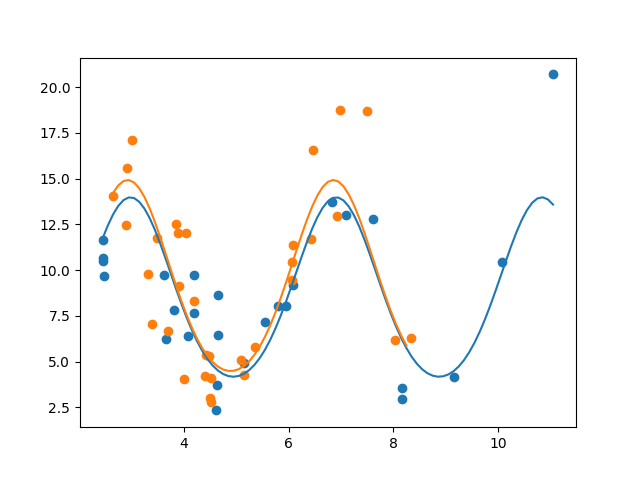

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 33
    # data points      = 27
    # variables        = 3
    chi-square         = 149.000368
    reduced chi-square = 6.20834867
    Akaike info crit   = 52.1190216
    Bayesian info crit = 56.0065322
[[Variables]]
    rhos0:  0.125 (fixed)
    rhob:   0.27 (fixed)
    k:      0.8 (fixed)
    D:      4480 (fixed)
    j:      0.40078511 +/- 0.00410253 (1.02%) (init = 0.5)
    delta:  1.51514598 +/- 0.12719438 (8.39%) (init = 2)
    a:      0.29949996 +/- 0.05141560 (17.17%) (init = 2)
[[Correlations]] (unreported correlations are < 0.100)
    C(j, a)     = -0.5286
    C(delta, a) = -0.1758
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 33
    # variables        = 3
    chi-square         = 235.525249
    reduced chi-square = 7.85084165
    Akaike info crit   = 70.8552486
    Bayesian info crit = 75.3447712
[[Variables]]
    rhos0:  0.125 (fixed)
    rho

In [62]:

plt.figure()

for d in [Ag, Co]:
    def model_(params, x):
        delta = params['delta']
        rhos0 = params['rhos0']
        rhob = params['rhob']
        k = params['k']
        D = params['D']
        j = params['j']
        a = params['a']

        model =  D*np.exp(-1./(j*(rhob+rhos0*(1+a*np.cos(2.*k*x+delta)))))
        return model
    
    def residual(params, x, data=None, uncertainty=None):

        model = model_(params, x)

        if uncertainty is None:
            return model - data
        return (model-data)/uncertainty

    params = Parameters()

    params.add('rhos0', value=0.125, vary=False)
    params.add('rhob', value=0.27, vary=False)
    params.add('k', value=0.8, vary=False)
    params.add('D', value=4480, min=0, max=5000, vary=False)

    params.add('j', value=0.5, min=0, max=1, vary=True)
    params.add('delta', value=2, min=0, max=2*np.pi, vary=True)
    params.add('a', value=2, min=0, max=5, vary=True)


    out = minimize(residual, params, args=(d[0],), kws={'data': d[1]})#, nan_policy='propagate')

    print(fit_report(out))

    plt.scatter(d[0], d[1])
    
    d0 = np.arange(min(d[0]), max(d[0]), 0.1)
    plt.plot(d0, model_(out.params, d0))
    #plt.plot(d[0], d[1]+out.residual)

# E: Fitting one J value and delta, with amplitude fixed to 0.3

<IPython.core.display.Javascript object>


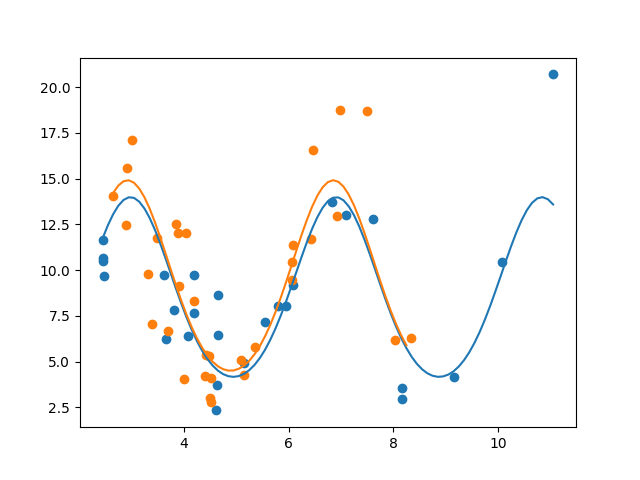

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 27
    # variables        = 2
    chi-square         = 149.000918
    reduced chi-square = 5.96003671
    Akaike info crit   = 50.1191212
    Bayesian info crit = 52.7107949
[[Variables]]
    rhos0:  0.125 (fixed)
    rhob:   0.27 (fixed)
    k:      0.8 (fixed)
    D:      4480 (fixed)
    j:      0.40076384 +/- 0.00341197 (0.85%) (init = 0.5)
    delta:  1.51490178 +/- 0.12249347 (8.09%) (init = 2)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 33
    # variables        = 2
    chi-square         = 235.530202
    reduced chi-square = 7.59774846
    Akaike info crit   = 68.8559425
    Bayesian info crit = 71.8489576
[[Variables]]
    rhos0:  0.125 (fixed)
    rhob:   0.27 (fixed)
    k:      0.8 (fixed)
    D:      4480 (fixed)
    j:      0.40526022 +/- 0.00331828 (0.82%) (init = 0.5)
    delta:  1.60126873 +/- 0.13302837 (

In [68]:
from numpy import exp, sin

from lmfit import minimize, Parameters, fit_report
plt.figure()

for d in [Ag, Co]:
    def model_(params, x):
        delta = params['delta']
        rhos0 = params['rhos0']
        rhob = params['rhob']
        k = params['k']
        D = params['D']
        j = params['j']

        model =  D*np.exp(-1./(j*(rhob+rhos0*(1+0.3*np.cos(2.*k*x+delta)))))
        return model
    
    def residual(params, x, data=None, uncertainty=None):
        model = model_(params,x)

        if uncertainty is None:
            return model - data
        return (model-data)/uncertainty

    params = Parameters()

    params.add('rhos0', value=0.125, vary=False)
    params.add('rhob', value=0.27, vary=False)
    params.add('k', value=0.8, vary=False)
    params.add('D', value=4480, min=0, max=5000, vary=False)

    params.add('j', value=0.5, min=0, max=1, vary=True)
    params.add('delta', value=2, min=0, max=2*np.pi, vary=True)

    out = minimize(residual, params, args=(d[0],), kws={'data': d[1]})#, nan_policy='propagate')

    print(fit_report(out))

    plt.scatter(d[0], d[1])
    d0 = np.arange(min(d[0]), max(d[0]), 0.1)
    plt.plot(d0, model_(out.params, d0))
    #plt.plot(d[0], d[1]+out.residual)

In [17]:
d = CircCorralData("/Users/akipnis/Desktop/Aalto Atomic Scale Physics/modeling and analysis/data/2022-05-16 H2Pc (2 min 300 C -130 C)/6p07 nm Monday corral/A220523.145912.dat", None, None)
d = CircCorralData("/Users/akipnis/Desktop/Aalto Atomic Scale Physics/modeling and analysis/data/2022-05-16 H2Pc (2 min 300 C -130 C)/7 nm corral/A220523.234720.dat", None, None)
d = CircCorralData("/Users/akipnis/Desktop/Aalto Atomic Scale Physics/modeling and analysis/data/2022-05-16 H2Pc (2 min 300 C -130 C)/6.7 nm corral/A220524.015654.dat", None, None)

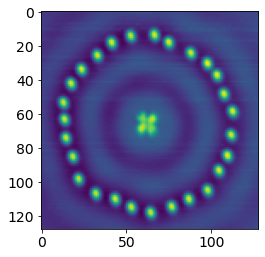

In [18]:
import matplotlib.pyplot as plt
plt.imshow(d.im)

using channel 0 instead of channel 2!
using channel 0 instead of channel 2!
using channel 0 instead of channel 2!
using channel 0 instead of channel 2!
using channel 0 instead of channel 2!
using channel 0 instead of channel 2!


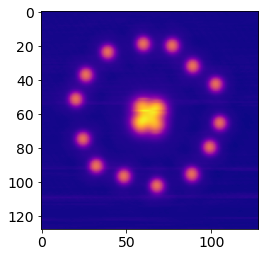

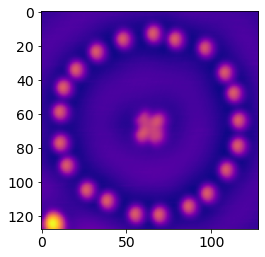

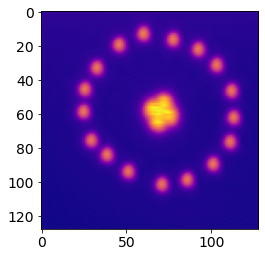

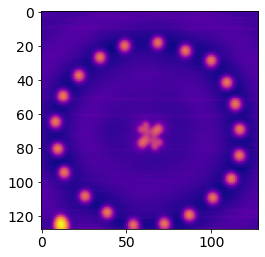

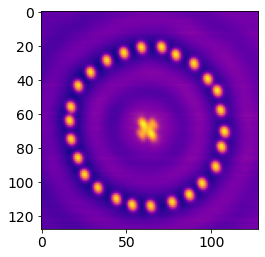

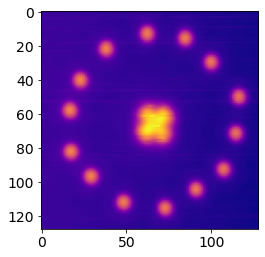

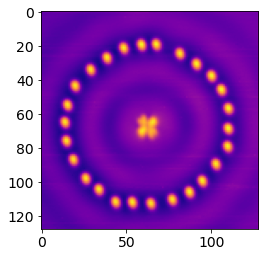

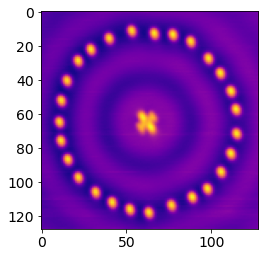

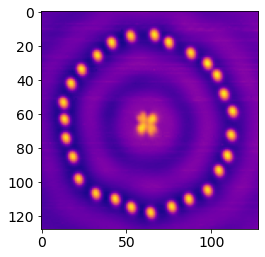

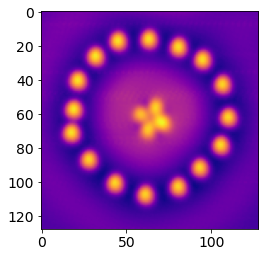

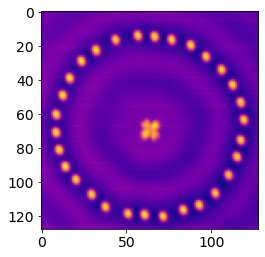

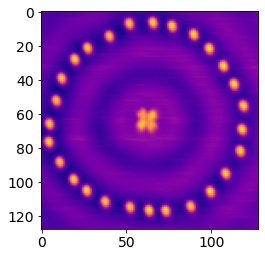

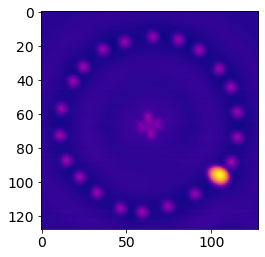

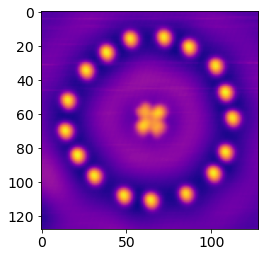

In [27]:
import os
f = "/Users/akipnis/Desktop/Aalto Atomic Scale Physics/modeling and analysis/data/2022-05-16 H2Pc (2 min 300 C -130 C)"
dirs = os.listdir(f)
for i in dirs:
    if os.path.isdir(os.path.join(f, i)):
        files = os.listdir(os.path.join(f,i))
        file = [f for f in files if f.endswith(".dat")][0]
        d = CircCorralData(os.path.join(f,i,file), None, None)
        plt.figure()
        plt.imshow(d.im, cmap='plasma')